In [8]:
import anndata as ad 
from ripser import ripser
from persim import plot_diagrams
from os.path import join

import matplotlib.pyplot as plt
import gseapy
from totopos import genes as tpg
import seaborn as sns
from topo import viz 
viz.set_plotting_style_plt()
fig_dir = "/home/mnu/projects/topo/figs/paper_figs/SI_cell_cycle_analysis"

import os
import numpy as np

In [2]:
ddir = "/home/mnu/projects/topo/data/human/formichetti"
fn="cell_cycle_wt_exons_hvg.h5ad"

In [3]:
a = ad.read_h5ad(join(ddir, fn))

In [4]:
a

AnnData object with n_obs × n_vars = 803 × 7402
    obs: 'n_counts', 'log_counts', 'n_genes', 'frac_mito', 'frac_ribo', 'pc1', 'pc2', 'pc3', 'pc4'
    var: 'gene_name', 'mean', 'log_mean', 'var', 'cv', 'log_cv', 'highly_variable'
    obsm: 'pcs'

In [5]:
ph = ripser(a.obsm["pcs"][:,:5],do_cocycles=True,)

In [9]:
lifetimes=ph["dgms"][1][:,1] - ph["dgms"][1][:,0]

In [10]:
isort=np.argsort(lifetimes)[::-1]

In [12]:
pd_pal = ["#000000","#212b61"]

In [13]:
from topo import viz

(0.0, 8.0)

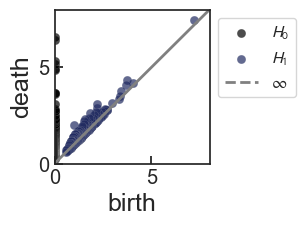

In [74]:
plt.figure(figsize=(2,2))
viz.plot_pers_diag_ripser(ph["dgms"], pal = pd_pal)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0,8)
plt.xlim(0,8)
# plt.savefig(
#     join(fig_dir, "cell_cycle_persdiag.png"), dpi = 700, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "cell_cycle_persdiag.pdf"), dpi = 700, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "cell_cycle_persdiag.svg"), dpi = 700, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "cell_cycle_persdiag.jpeg"), dpi = 700, bbox_inches="tight"
# )

In [18]:
from totopos import cells as tpc

In [19]:
pcs=a.obsm["pcs"][:,:5]

In [20]:
homology_data =tpc.critical_edge_method(pcs,ph,n_loops=3,verbose=True)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Starting VR graph construction.


 33%|█████████████████████▋                                           | 1/3 [00:00<00:01,  1.10it/s]

Finished VR graph. Starting 1-th loop discovery...
Finished computing loop from VR graph.
Starting VR graph construction.


 67%|███████████████████████████████████████████▎                     | 2/3 [00:01<00:00,  1.10it/s]

Finished VR graph. Starting 2-th loop discovery...
Finished computing loop from VR graph.
Starting VR graph construction.


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

Finished VR graph. Starting 3-th loop discovery...
Finished computing loop from VR graph.
Finished critical edge algorithm.


In [21]:
import numpy as np

In [23]:
topocells, tpc_idx = tpc.get_loop_neighbors(pcs,pcs[np.unique(homology_data[0]["loop"])],homology_data[0]["birth_dist"]+5e-2)

In [24]:
ada_tpc=a[tpc_idx].copy()

In [25]:
pal = viz.categorical_large_list()

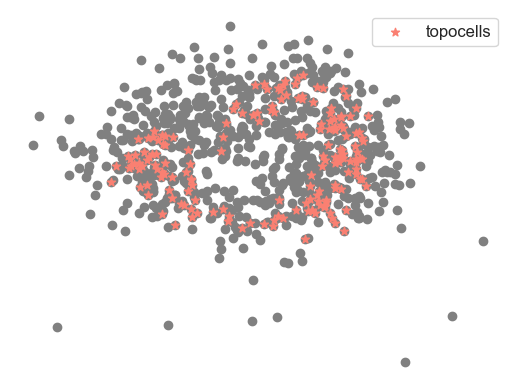

In [27]:
plt.scatter(*pcs[:,(1,3)].T, color = "grey")
plt.scatter(*topocells[:,(1,3)].T, marker="*", color = "salmon", label="topocells")
plt.axis("off")
plt.legend();

In [29]:
cc_ddir = "/home/mnu/projects/topo/data/human/cell_cycle_metadata/"

## 1. Load count matrix and cell cycle genes  
s_phase_genes = np.loadtxt(join(cc_ddir, "s_genes.txt"), dtype=str)
m_phase_genes = np.loadtxt(join(cc_ddir, "g2m_genes.txt"), dtype=str)

In [30]:
gene_col_name="gene_name"

In [31]:
s_phase_genes

array(['ATAD2', 'BLM', 'BRIP1', 'CASP8AP2', 'CCNE2', 'CDC45', 'CDC6',
       'CDCA7', 'CHAF1B', 'CLSPN', 'DSCC1', 'DTL', 'EXO1', 'FEN1',
       'GINS2', 'GMNN', 'HELLS', 'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MLF1IP',
       'MSH2', 'NASP', 'PCNA', 'POLA1', 'POLD3', 'PRIM1', 'RAD51',
       'RAD51AP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2', 'SLBP', 'TIPIN',
       'TYMS', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'], dtype='<U8')

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
s_data = a[:, a.var[gene_col_name].isin(s_phase_genes)].X.A
s_zscores = StandardScaler().fit_transform(s_data)
s_scores = s_zscores.mean(1)
#s_scores = np.clip(s_scores, -6, 6)

m_data = a[:, a.var[gene_col_name].isin(m_phase_genes)].X.A
m_zscores = StandardScaler().fit_transform(m_data)
m_scores = m_zscores.mean(1)
#m_scores = np.clip(m_scores, -6, 6)

In [34]:
s_data.shape, m_data.shape

((803, 21), (803, 34))

In [35]:
import pandas as pd

In [36]:
phase = pd.Series("S", index=a.obs.index)

cat=np.concatenate

scores=cat((s_scores.reshape(-1,1), m_scores.reshape(-1,1)),1)

phase[m_scores > s_scores] = "G2M"

# if all scores are negative, it's G1...
phase[np.all(scores < 0, axis=1)] = "G1"

a.obs["phase"] = phase.values

(-4.054036426544189,
 3.4599202156066893,
 -3.200018084049225,
 2.8018521428108216)

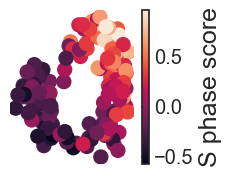

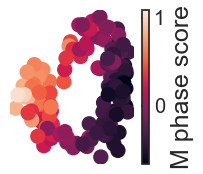

In [38]:
plt.figure(figsize=(2,2))
plt.scatter(*topocells[:,(1,3)].T, c = s_scores[tpc_idx], s= 100)
plt.colorbar(label="S phase score")
plt.axis("off")

plt.figure(figsize=(2,2))
plt.scatter(*topocells[:,(1,3)].T, c = m_scores[tpc_idx], s= 100)
plt.colorbar(label="M phase score")
plt.axis("off")

In [39]:
phase_codes, _ = pd.factorize(phase)

In [40]:
u,v=homology_data[0]["loop"][0]

In [41]:
u,v

(79, 101)

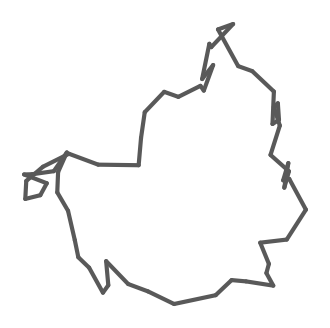

In [43]:
fig=viz.visualize_h1_2d(
    data = pcs[:, (1,3)],h1_simplex_list=[homology_data[0]["loop"]],draw_scatter=False, pal= ["#595959"]
)

In [44]:
plt.figure(figsize=(3, 3))
sns.scatterplot(
    a[tpc_idx].obs,
    x="pc2",
    y="pc4",
    hue="phase",
    palette= sns.cubehelix_palette(start=.8, rot=-.7, reverse=False, as_cmap=False), #["#b47f6a", "#cfc0a8", "#373a32"],
    s=200,
    hue_order = ["G1", "S", "G2M"],
    linewidths=1,
    edgecolor="lightgrey",
    alpha = .7, 
    ax = fig.axes[0]
)

fig.axes[0].axis("off")
fig.axes[0].legend(bbox_to_anchor=(1, 1), title = "cell cycle phase",)

/tmp/ipykernel_1624070/3728380078.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(


<Figure size 300x300 with 0 Axes>

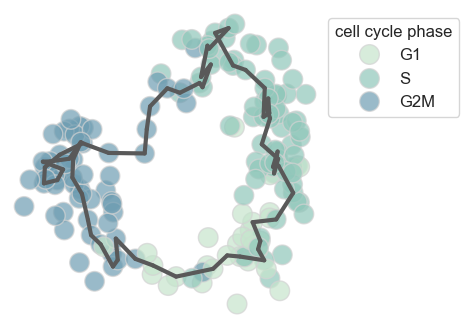

In [45]:
fig

In [46]:
# fig.savefig(
#     join(fig_dir, "loop_scatter_by_cell_cycle_phase.png"), 
#     dpi=700, 
#     bbox_inches="tight"
# )

# fig.savefig(
#     join(fig_dir, "loop_scatter_by_cell_cycle_phase.pdf"), 
#     dpi=700, 
#     bbox_inches="tight"
# )

# fig.savefig(
#     join(fig_dir, "loop_scatter_by_cell_cycle_phase.jpeg"), 
#     dpi=700, 
#     bbox_inches="tight"
# )

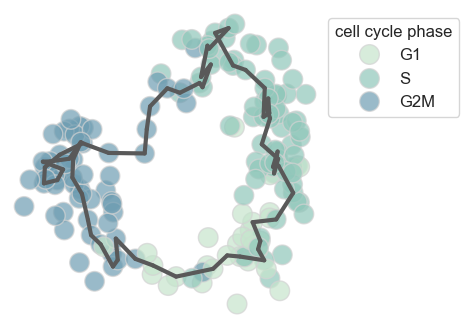

In [47]:
fig

In [54]:
grads, topo_ranking=tpg.topological_scores_perturbation_torch_ripser(a, ph, n_pcs=5,)

In [55]:
isort_tpg = np.argsort(topo_ranking)[::-1]

In [56]:
n_topogenes=500

In [57]:
topoGenes=a.var.gene_name.values[isort_tpg[:n_topogenes]]

In [58]:
s_phase_topogenes=set(s_phase_genes).intersection(set(topoGenes))

In [59]:
len(s_phase_topogenes)/len(s_phase_genes)

0.42857142857142855

In [60]:
m_phase_topogenes=set(m_phase_genes).intersection(set(topoGenes))

In [61]:
len(m_phase_topogenes)/len(m_phase_genes)

0.5454545454545454

In [62]:
genes_viz = list(m_phase_topogenes)[:5] + list(s_phase_genes)[5:10]

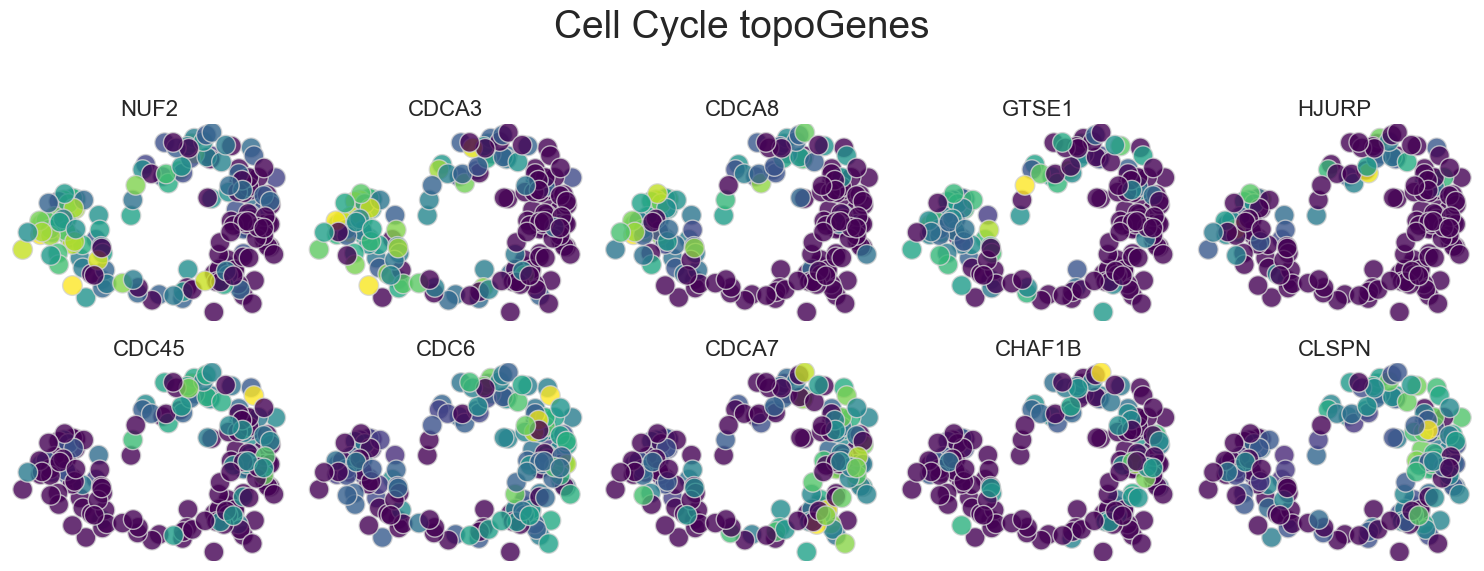

In [79]:
n_plots = 10
rows, cols = 2, 5  # 5 rows and 4 columns for a 5x4 grid
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))  # Adjusted figure size for better layout
fig.suptitle("Cell Cycle topoGenes", fontsize=28)  # Add a title for the entire figure

# Loop through the grid and populate each subplot
for i, ax in enumerate(axes.flat):
    if i < n_plots:  # Only plot if within the number of desired plots
        g = genes_viz[i]
        ax.scatter(
            *topocells[:, (1,3)].T, 
            c=ada_tpc[:, ada_tpc.var.gene_name==g].X.A.flatten(),
            cmap="viridis", s= 200, edgecolor="lightgrey", alpha = .8
        )
        #gn = g.split("|")[1]
        ax.set_title(g, fontsize=16)
        ax.axis("off")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
fig.savefig(join(fig_dir, "cell_cycle_topogene_grid.png"),dpi=320,bbox_inches="tight")
fig.savefig(join(fig_dir, "cell_cycle_topogene_grid.pdf"),dpi=320,bbox_inches="tight")
fig.savefig(join(fig_dir, "cell_cycle_topogene_grid.svg"),dpi=320,bbox_inches="tight")
fig.savefig(join(fig_dir, "cell_cycle_topogene_grid.jpeg"),dpi=320,bbox_inches="tight")

In [64]:
df_enrichment=gseapy.enrichr(
    gene_list = list(topoGenes), gene_sets = ["Panther_2016", "KEGG_2021_Human", "Reactome_2022",]
).results

In [65]:
df_enr_reactome= df_enrichment[df_enrichment["Gene_set"]=="Reactome_2022"].sort_values(by="Adjusted P-value")

In [66]:
df_enr_reactome.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
281,Reactome_2022,Cell Cycle R-HSA-1640170,69/654,1.777729e-24,1.603512e-21,0,0,5.176334,283.076658,HJURP;BUB1B;BRCA1;SYNE2;CDC20;CCND1;EXO1;MIS18...
282,Reactome_2022,"Cell Cycle, Mitotic R-HSA-69278",55/523,1.469768e-19,6.628653e-17,0,0,5.026217,217.956946,BUB1B;CDC20;CCND1;PPME1;NUF2;CDC27;EP300;NEK2;...
283,Reactome_2022,Cell Cycle Checkpoints R-HSA-69620,36/271,2.485386e-16,7.472728e-14,0,0,6.360418,228.535763,RNF8;CDCA8;BUB1B;BRCA1;PKMYT1;CENPA;AURKB;CDC2...
284,Reactome_2022,Mitotic Prometaphase R-HSA-68877,27/186,1.669499e-13,3.764720e-11,0,0,6.943596,204.288103,CDCA5;BUB1B;CDCA8;NCAPG;CENPA;NCAPH;AURKB;CDC2...
285,Reactome_2022,EML4 And NUDC In Mitotic Spindle Formation R-H...,20/97,2.863335e-13,5.165456e-11,0,0,10.510281,303.553945,CENPU;DYNC1H1;PLK1;BUB1B;CDCA8;CKAP5;CENPA;NDC...


In [67]:
df_enr_reactome["reactome_label"] = df_enr_reactome["Term"].str.split("R-HSA",expand=True)[0]

In [68]:
df_enr_reactome["-logpval"] = -np.log(df_enr_reactome["Adjusted P-value"])

/tmp/ipykernel_1624070/1987077132.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'topoGene enrichment test')

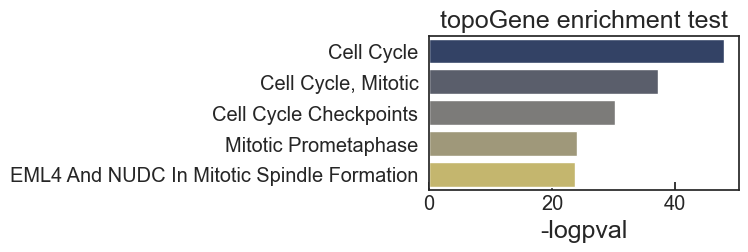

In [69]:
plt.figure(figsize=(4,2))
sns.barplot(
    data=df_enr_reactome.head(5),
    x="-logpval", 
    y = "reactome_label",
    palette = "cividis"
)
plt.ylabel("")
plt.title("topoGene enrichment test", fontsize=18)
# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.png"), dpi = 500, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.pdf"), dpi = 500, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.jpeg"), dpi = 500, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.svg"), dpi = 500, bbox_inches="tight"
# )